# Logistic Regression (in 1D)

**Topics**:
- Gradient-based learning
- Regularization
- Stochastic gradient descent (SGD)
- Backpropagation

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

## Logistic regression

Logistic regression is a **binary classifier**. We model the conditional probability of label $1$ under $x$ as the output of a sigmoid function that receives, as input, the distance of a point to a separating hyperplane, parameterized by $w$ and $b$. Formally, 

$$P(y=1|x) = sigm(\langle w,x \rangle + b),$$

where 

$$sigm(x) = \frac{1}{1+e^{-x}}\enspace.$$

is the **sigmoid** function. So, for $x=0$, the sigmoid returns 0.5. If interpreted as the probability of class label 1 given $x$, this means that the classifier would be undecided (i.e., random guessing if $x$ should have label 0 or 1).

In [2]:
print('sigm(0)={}'.format(F.sigmoid(torch.Tensor([0])).item()))

sigm(0)=0.5


So, in 1D, we have

$$P(y=1|x) = \frac{1}{1+e^{(-wx+b)}}$$

Our labels are in $\{0,1\}$. Our data points $x$ in $\mathbb{R}$. If we want to fit our model to a training set of $N$ points $(x_i,y_i)$, we need a way to measure the quality of the fit. However, our targets are binary variables (i.e., class labels, either $0$ or $1$); so, taking the mean-squared error is not a good choice. 

We can, however, decide to model $P(y|x)$ as a **Bernoulli random variabe**, where the probability of event $1$ is given by the sigmoid function. Assuming all $x_i$ are **independent and identically (iid)** distributed, we can write

$$ p((y_1,\ldots,y_n)|X=(x_1,\ldots,x_n)) = \prod_i \left( \frac{1}{1+\exp^{-(wx_i+b)}} \right)^{y_i} 
\left(1-\frac{1}{1+\exp^{-(wx_i+b)}} \right)^{1-y_i}$$

## Objective

Now, our goal is to choose $(w,b)$ such that this likelihood is **maximized**. We also switch to log-space for numerical stability and get

$$J(\theta) := p((y_1,\ldots,y_n)|X=(x_1,\ldots,x_n)) = \sum_i y_i \log(\pi_i) + (1-y_i)\log(1-\pi_i)$$

where the $\pi_i$'s are given by

$$ \pi_i =  \frac{1}{1+\exp^{-(wx+b)}}$$

#### Taking the gradient w.r.t. parameters

Since the derivative of a sum is the sum of the derivatives, we just look at one term in the summation first and take the derivative w.r.t. $\theta_j$, i.e., the $j$-th element of the paramter vector.


$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{y}{sigm(\theta^\top x)}\frac{\partial}{\partial \theta_j}sigm(\theta^\top x) + \frac{1-y}{1-sigm(\theta^\top x)}\frac{\partial}{\partial \theta_j}sigm(\theta^\top x) $$

Collecting terms gives

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left[\frac{y}{sigm(\theta^\top x)}-\frac{1-y}{1-sigm(\theta^\top x)}\right]\frac{\partial}{\partial \theta_j}sigm(\theta^\top x)$$

Now, take the derivative of the sigmoid function w.r.t. $\theta_j$, i.e.,

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left[\frac{y}{sigm(\theta^\top x)}-\frac{1-y}{1-sigm(\theta^\top x)}\right]sigm(\theta^\top x)[1-sigm(\theta^\top x)]x^{(j)}$$

where $x^{(j)}$ is the $j$-th element of $x$. Finally, after collecting terms and simplification, we get

$$ \frac{\partial J(\theta)}{\partial \theta_j} = [y-sigm(\theta^\top x)]x^{(j)}  $$

That is the derivative of the cost function w.r.t. the $j$-th parameter.  Taking the sum into account again, we obtain

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \sum_i [y_i-sigm(\theta^\top x_i)]x_i^{(j)}  $$

#### Optimization

Since we want to **maximize** the cost, we walk into the direction of the gradient in *small* steps (controlled by $\alpha$, aka the **learning rate** in deep learning lingo). This strategy is called **gradient ascent**. 

Alternatively, we could have taken the negative log-likelihood as our cost. Hence, we would walk into the direction of the negative gradient and obtain a **gradient descent** optimization approach. Let's do the latter, as this is more common in practice.

In case of minimizing the negative log-likelihood, we have

$$ \frac{\partial J(\theta)}{\partial \theta_j} = [sigm(\theta^\top x)-y]x^{(j)}  $$

Consequently, our parameter update rule is

$$ \theta_j^{k+1} = \theta_j^{k} - \alpha \frac{\partial J(\theta^k)}{\partial \theta_j^{k}}$$


#### Toy Example 

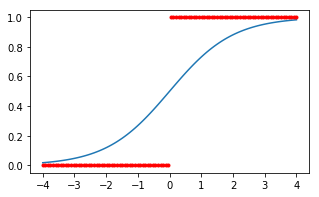

In [3]:
import math

# True paramters
w_true = +1
b_true = 0 # for simplicity

# Get x values linearly spaced in [-4,4]
x = np.linspace(-4,4,100)

# Compute <w, x> + b
y = (w_true*x + b_true)

# Define the sigmoid function
sigm = lambda x: 1/(1+math.exp(-x))

# Map all values of y to sigm(y)
y = np.array(list(map(sigm, y)))

# Create a 0/1 labels by setting all values in y>=0.5 to 1, others to 0
z = np.array(list(map(lambda y: 1 if y>=0.5 else 0, y)))

plt.figure(figsize=(5,3))
plt.plot(x,y)  
plt.plot(x,z,'r.')

## Using sklearn's logistic regression

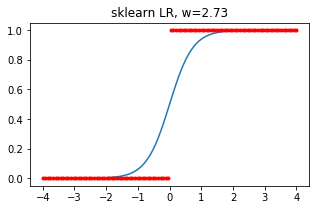

In [4]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression() # default paramters
lr.fit(x.reshape(-1,1),z)

x = np.linspace(-4,4,100)
y = (lr.coef_[0]*x + 0)
y = np.array(list(map(lambda x: 1/(1+math.exp(-x)), y)))

plt.figure(figsize=(5,3))
plt.plot(x,y)
plt.plot(x,z,'r.')
plt.title('sklearn LR, w={:.2f}'.format(lr.coef_[0][0]));

## Using our own optimziation routine

Lets implement the **gradient decent routine**.

In [5]:
w_cur     = 0.1 # initial estimate of w
alpha     = 0.5 # step_size for gradient descent

for n in range(500): # update 500-times
    t0 = [v*(sigm(w_cur*v)-y) for v,y in zip(x,z)]
    grad = np.mean(np.array(t0)) 
    w_new = w_cur - alpha*grad
    w_cur = w_new
print(w_cur)

5.350688453429106


*What happend here?* $w$ is way to large. Effectively, we have totally **overfit** to the data. How do we counteract this? This is called **regularization** and one way to achieve this is to penalize large weights. E.g., by adding 

$$ R[w] = \frac{\lambda}{2} w^2 $$

to our objective, i.e., $J(\theta) + R[\theta]$. 

This is the 1-D variant of a so called **Tikhonov regularizer**. In general, for vector-valued $w$, we would have 

$$ R[w] = \frac{\lambda}{2} \| w \|^2$$

In the 1-D variant, the gradient is simply $\lambda w$. Lets try this. By the way, adding the regularizer now has a name: **regularized logistic regression** (what a surprise).

In [6]:
w_cur     = 0.1
alpha     = 0.5 
lam       = 0.01 # how much do we want to penalize

for n in range(500):
    # same as above
    t0 = [v*(sigm(w_cur*v)-y) for v,y in zip(x,z)]
    # now we add the gradient of the regularizer
    grad = np.mean(np.array(t0)) + lam*w_cur
    w_new = w_cur - alpha*grad
    w_cur = w_new
print(w_cur)

2.7308529228633827


Play around with this and you will see that the more you penalize (i.e., the more $\lambda$ grows), it will hold back the optimization from increasing $w$.

**Note**: In machine learning, our objective $-J(\theta)$ is called the **binary cross entropy** loss. "Binary" because we have two classes and "cross entropy" because, 
we effectively measure the cross entropy between target and output.

## Logistic regression as a neural network

We can also write the logistic regression model as a simple neural network. For that purpose, we create a Python class that derives from PyTorch's `torch.nn.Module`. The great thing is that we will not have to care about the gradients anymore, as this will be computed for us automatically (aka. automatic differentiation, aka autograd :).

### Data loading

### Model definition

In [7]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # implements <w,x> + b
        self.linear = torch.nn.Linear(1, 1, bias=False) 

    def forward(self, x):
        # implements 1/(1+exp(-<w,x>+b))
        y_pred = F.sigmoid(self.linear(x)) 
        return y_pred
    
# Lets instantiate that model
model = Model()

Lets look at the current output of the model (uninitialized) ...

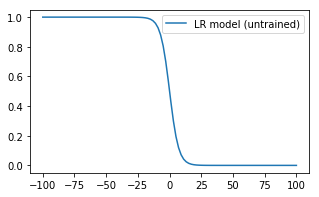

In [8]:
import numpy as np

x_i = torch.Tensor(np.linspace(-100,100,100).T).unsqueeze(1) # (100,1)
y_i = model(x_i)

plt.figure(figsize=(5,3))
plt.plot(x_i.detach().numpy(),y_i.detach().numpy())
plt.legend(['LR model (untrained)'])

In [9]:
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import SGD

x = np.linspace(-4,4,100, dtype=np.float32)
y = (w_true*x + b_true)
sigm = lambda x: 1/(1+math.exp(-x))
y = np.array(list(map(sigm, y)))
z = np.array(list(map(lambda y: 1 if y>=0.5 else 0, y)),dtype=np.float32)

# make sure we have tensors
X = torch.from_numpy(x).unsqueeze(1)
Z = torch.from_numpy(z).unsqueeze(1)

# create a tensor dataset, so we can easily use the DataLoader
ds = TensorDataset(X,Z)
# create a data loader that will provide batches of size 16
# and shuffle the training data.
dl = DataLoader(ds, batch_size=16, shuffle=True)

# create new model
model = Model()

# create optimizer
opt = SGD(model.parameters(), # [w,(b)]
          lr=1e-1,            # learning rate (for paramter update)
          weight_decay=1e-2)  # weight decay = l2 penalty on weights

# binary cross entropy loss
bce = torch.nn.BCELoss()

In [10]:
losses = []
for epoch in range(500):
    epoch_loss = 0
    for (x,y) in dl:
        model.zero_grad()
        out = model(x)
        loss = bce(out, y)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()
    if epoch % 100 == 0:
        print(epoch, epoch_loss)
    losses.append(epoch_loss)

0 7.934542417526245
100 0.48763648071326315
200 0.6996221160516143
300 0.49535821191966534
400 0.4758445033803582


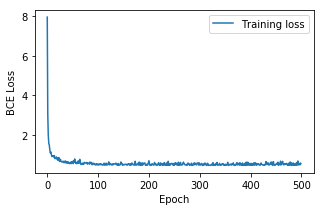

In [11]:
plt.figure(figsize=(5,3))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.legend(['Training loss'])

In [12]:
print(model.linear.weight)

Parameter containing:
tensor([[ 2.7329]])
